In [1]:
# MODIFY! 
model_name = 'ela-net-st-no'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/d-wo-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

In [6]:
# MODIFY!
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV(l1_ratio=[.1, .5, .7,.8,.9, .95, .99, 1],max_iter=1000000,cv=10)
model

ElasticNetCV(cv=10, l1_ratio=[0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 1],
             max_iter=1000000)

In [7]:
model.fit(X_train, y_train)

ElasticNetCV(cv=10, l1_ratio=[0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 1],
             max_iter=1000000)

In [8]:
model.l1_ratio_

0.7

In [9]:
model.alpha_

0.09815724571147283

In [10]:
hp = pd.Series(name=f'{model_name} HP', data=[model.l1_ratio_, model.alpha_],index=['l1_ratio','alpha'])

In [11]:
hp

l1_ratio    0.700000
alpha       0.098157
Name: ela-net-st-no HP, dtype: float64

In [12]:
hp.to_csv(f'./hyperparameters/{model_name}.csv')

# Score Model

In [13]:
# MODIFY!
from sklearn.linear_model import ElasticNet

score_model = ElasticNet(
    alpha = model.alpha_,
    l1_ratio = model.l1_ratio_
)

score_model

ElasticNet(alpha=0.09815724571147283, l1_ratio=0.7)

In [14]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [15]:
scores = pd.DataFrame(scores)

In [16]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.039253,0.022498,-3.228518,-16.626641,-4.077578
1,0.013219,0.002596,-3.185410,-18.801171,-4.336032
2,0.008258,0.003005,-3.355450,-17.393918,-4.170602
3,0.009088,0.002911,-3.173925,-21.871121,-4.676657
4,0.018293,0.004732,-3.304606,-19.585479,-4.425548
5,0.008110,0.006521,-3.483905,-21.465605,-4.633099
6,0.015845,0.005498,-3.265753,-17.003521,-4.123533
7,0.005512,0.001735,-3.344658,-20.458258,-4.523081
8,0.052205,0.008129,-3.352773,-19.771509,-4.446517
9,0.009743,0.005207,-3.471645,-21.581502,-4.645590


In [17]:
mean_scores = scores.mean()

In [18]:
mean_scores

fit_time                             0.017953
score_time                           0.006283
test_neg_mean_absolute_error        -3.316664
test_neg_mean_squared_error        -19.455873
test_neg_root_mean_squared_error    -4.405823
dtype: float64

# Export Model Score

In [19]:
mean_scores = mean_scores.rename(f'{model_name}')

In [20]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [21]:
# mean_scores

In [22]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [23]:
mean_scores

Fit Time       0.017953
Score Time     0.006283
MAE            3.316664
MSE           19.455873
RMSE           4.405823
Name: ela-net-st-no, dtype: float64

In [24]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [25]:
mean_scores

Fit Time       0.017953
Score Time     0.006283
MAE            3.316664
MSE           19.455873
RMSE           4.405823
STD FT         0.015440
STD ST         0.006027
STD MAE        0.107336
STD MSE        1.949667
STD RMSE       0.222591
Name: ela-net-st-no, dtype: float64

In [26]:
mean_scores.to_csv(f'./scores/{model_name}.csv')

# Holdout Test

In [27]:
score_model.fit(X_train,y_train)

ElasticNet(alpha=0.09815724571147283, l1_ratio=0.7)

In [28]:
y_holdout = score_model.predict(X_test)

<AxesSubplot:ylabel='Count'>

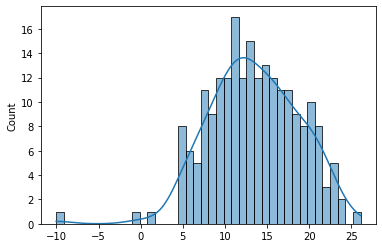

In [29]:
sns.histplot(y_holdout,bins=40,kde=True)

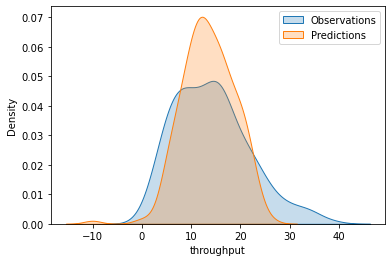

In [30]:
fig,ax = plt.subplots()

sns.kdeplot(y_test, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_holdout, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

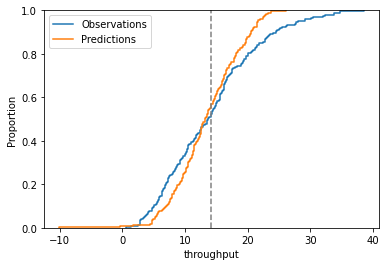

In [31]:
fig,ax = plt.subplots()

sns.ecdfplot(y_test, ax=ax, label='Observations')
sns.ecdfplot(y_holdout, ax=ax,label='Predictions')
plt.axvline(x=y_test.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_holdout)
mse = mean_squared_error(y_test,y_holdout)
rmse = np.sqrt(mse)

In [33]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,ela-net-st-no
MAE,3.961789
MSE,26.622374
RMSE,5.159687


In [34]:
err_df.to_csv(f'./holdout-test/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [35]:
res = y_test - y_holdout
res.describe().drop('count')

mean     0.668861
std      5.128090
min    -12.404868
25%     -2.885537
50%     -0.491352
75%      3.497794
max     17.544143
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

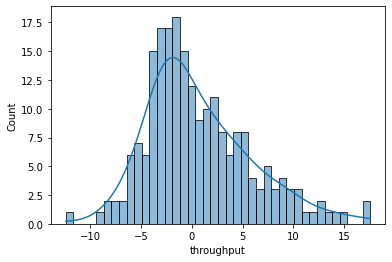

In [36]:
sns.histplot(data=res, kde=True,bins=40)

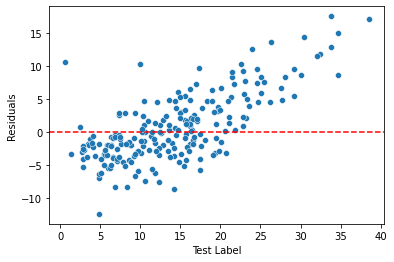

In [37]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

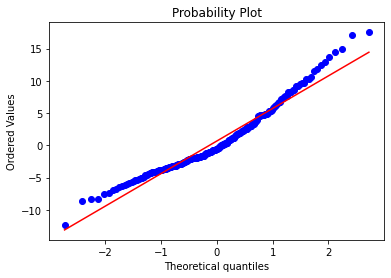

In [38]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

# Export Optimized Model

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [40]:
# MODIFY! 
X = scaler.transform(X)

op_model = score_model

op_model.fit(X,y)

ElasticNet(alpha=0.09815724571147283, l1_ratio=0.7)

In [41]:
y_pred = op_model.predict(X)

<AxesSubplot:ylabel='Count'>

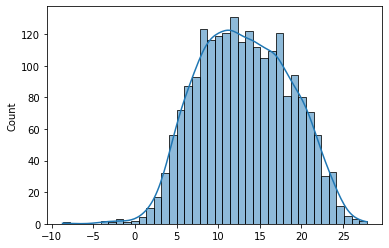

In [42]:
sns.histplot(y_pred,bins=40,kde=True)

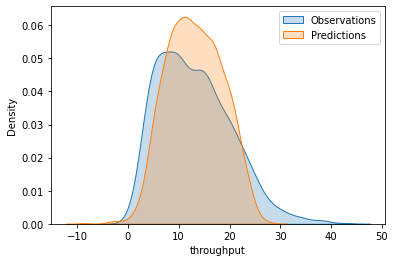

In [43]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

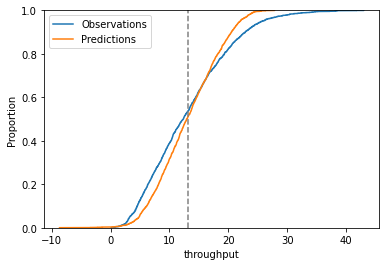

In [44]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [45]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)

In [46]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,ela-net-st-no
MAE,3.282939
MSE,18.814520
RMSE,4.337571


In [47]:
err_df.to_csv(f'./model-err/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [48]:
from joblib import dump, load
dump(op_model, f'./opt-models/{model_name}.joblib')

['./opt-models/ela-net-st-no.joblib']

In [49]:
res = y - y_pred
res.describe().drop('count')

mean   -1.232913e-15
std     4.338584e+00
min    -1.580648e+01
25%    -2.880706e+00
50%    -3.761060e-01
75%     2.388370e+00
max     3.508293e+01
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

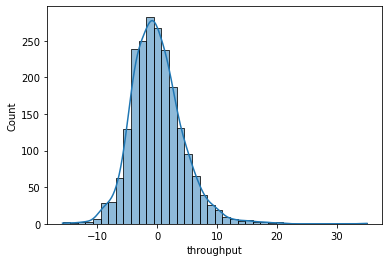

In [50]:
sns.histplot(data=res, kde=True,bins=40)

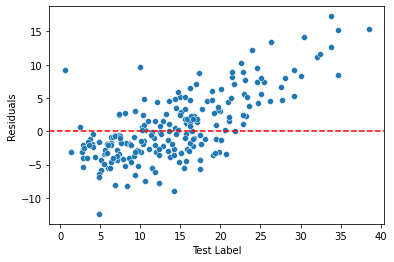

In [51]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

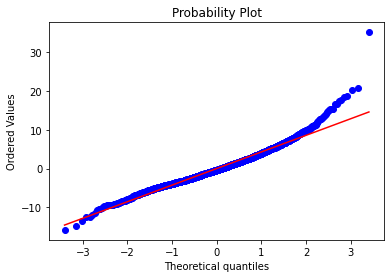

In [52]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

DONE!